In [1]:
#@title Import and set ups{ display-mode: "form" }

%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np
import tensorflow
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

import subprocess
import pymongo
import motor.motor_asyncio
import bson
import bson.json_util
from bson.codec_options import CodecOptions
from bson.raw_bson import RawBSONDocument

import datetime

from scipy import interpolate

import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.dataset as ds

import multiprocessing as mp

import gc

from numpy.random import default_rng

tf.enable_v2_behavior()
#tf.config.experimental.enable_tensor_float_32_execution(False)
print("TensorFloat-32: " + str(tf.config.experimental.tensor_float_32_execution_enabled()))

TensorFloat-32: True


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

In [4]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)

  num_steps = len(y)
  num_steps_forecast = forecast_mean.shape[-1]
  num_steps_train = num_steps - num_steps_forecast


  ax.plot(x, y, lw=2, color=c1, label='ground truth')

  forecast_steps = np.arange(
      x[num_steps_train],
      x[num_steps_train]+num_steps_forecast,
      dtype=x.dtype)

  ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

  ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
           label='forecast')
  ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

In [5]:
def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
  """Plot the contributions of posterior components in a single figure."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  axes_dict = collections.OrderedDict()
  num_components = len(component_means_dict)
  fig = plt.figure(figsize=(12, 2.5 * num_components))
  for i, component_name in enumerate(component_means_dict.keys()):
    component_mean = component_means_dict[component_name]
    component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
      ax.xaxis.set_major_locator(x_locator)
      ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
  fig.autofmt_xdate()
  fig.tight_layout()
  return fig, axes_dict

In [6]:
def plot_one_step_predictive(dates, observed_time_series,
                             one_step_mean, one_step_scale,
                             x_locator=None, x_formatter=None):
  """Plot a time series against a model's one-step predictions."""

  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]

  fig=plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1,1,1)
  num_timesteps = one_step_mean.shape[-1]
  ax.plot(dates, observed_time_series, label="observed time series", color=c1)
  ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
  ax.fill_between(dates,
                  one_step_mean - one_step_scale,
                  one_step_mean + one_step_scale,
                  alpha=0.1, color=c2)
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()
  fig.tight_layout()
  return fig, ax

In [7]:
exchange = "coinbasepro"
#exchange = "bitmex"
#exchange = "gdax"
#exchange = "kraken"
orderbook_path = f"orderbook_{exchange}"
ticker_path = f"ticker_{exchange}"
#ticker_path = "ticker_coinmarketcap"

In [8]:
ticker_dataset = ds.dataset(f'/data/{ticker_path}', format="parquet", partitioning="hive")
ticker_table = ticker_dataset.to_table()
ticker_df = ticker_table.to_pandas().drop(columns=['dt'])
ticker_df_clean = ticker_df[~ticker_df.index.duplicated(keep='first')]
volume_f = interpolate.interp1d(ticker_df_clean.index.to_numpy().astype('float'), ticker_df_clean['Volume'].to_numpy(),
    bounds_error=False,
    fill_value=(ticker_df_clean.iloc[0].Volume,ticker_df_clean.iloc[-1].Volume), 
    kind="linear")

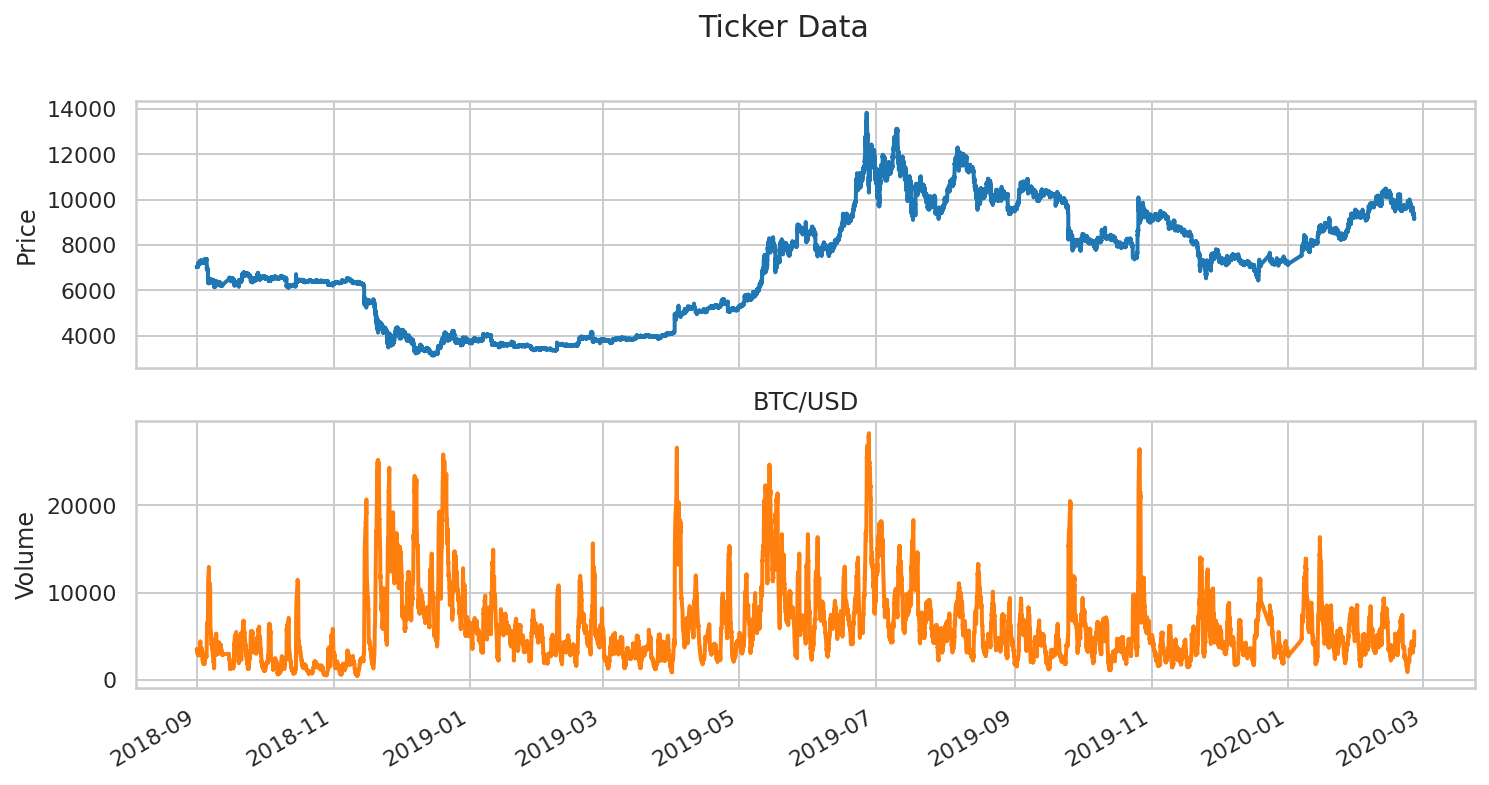

In [9]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(ticker_table['__index_level_0__'], ticker_table['Price'], lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(ticker_table['__index_level_0__'], ticker_table['Volume'], lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()

In [10]:
orderbook_dataset = ds.dataset(f'/data/{orderbook_path}', format="parquet", partitioning="hive")

In [11]:
orderbook_df_part = orderbook_dataset.to_table(filter=ds.field('dt') == '2019-01-26').to_pandas().drop(columns=['dt'])
orderbook_df_part

,Price,-0.000000500000,-0.000000509296,-0.000000518764,-0.000000528409,-0.000000538233,-0.000000548239,-0.000000558432,-0.000000568814,-0.000000579389,...,0.004236137071,0.004314892739,0.004395112584,0.004476823828,0.004560054197,0.004644831934,0.004731185807,0.004819145118,0.004908739715,0.005000000000
2019-01-26 00:00:19.397,3560.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.279403,7.150330,0.358548,1.361869,1.649079,0.007580,0.007721,3.305743,0.734261,0.046642
2019-01-26 00:00:49.192,3560.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.279403,7.150330,0.358548,1.361869,1.649079,0.007580,0.007721,3.305743,0.734261,0.046642
2019-01-26 00:01:26.129,3560.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.279403,7.150330,0.358548,1.361869,1.649079,0.007580,0.007721,3.305743,0.734261,0.046642
2019-01-26 00:02:00.294,3560.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.279403,7.150330,0.358548,1.361869,1.649079,0.007580,0.007721,3.305743,1.585897,1.082868
2019-01-26 00:02:19.629,3560.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.279403,7.150330,0.358548,1.361869,1.649079,0.007580,0.007721,3.305743,0.734261,0.046642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-26 23:57:29.117,3556.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.380478,2.137506,2.865252,0.512998,0.185833,1.520728,56.335271,1.428799,1.455362,1.482420
2019-01-26 23:58:09.674,3556.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.305089,2.464039,2.725032,0.182441,0.185833,6.062766,51.990221,1.428799,1.455362,1.482420
2019-01-26 23:58:40.123,3556.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.537677,2.344097,2.272387,0.182441,0.185833,6.062766,51.990221,1.428799,1.455362,1.482420
2019-01-26 23:59:00.447,3556.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.537677,2.344097,2.272387,0.182441,0.185833,6.062766,51.990221,1.428799,1.455362,1.482420


In [12]:
batches = []
idx=0
for scan_task in orderbook_dataset.scan(columns=['__index_level_0__','Price']):
    for record_batch in scan_task.execute():
        batches.append(record_batch.to_pandas())
        idx+=1
orderbook_prices = pd.concat(batches)

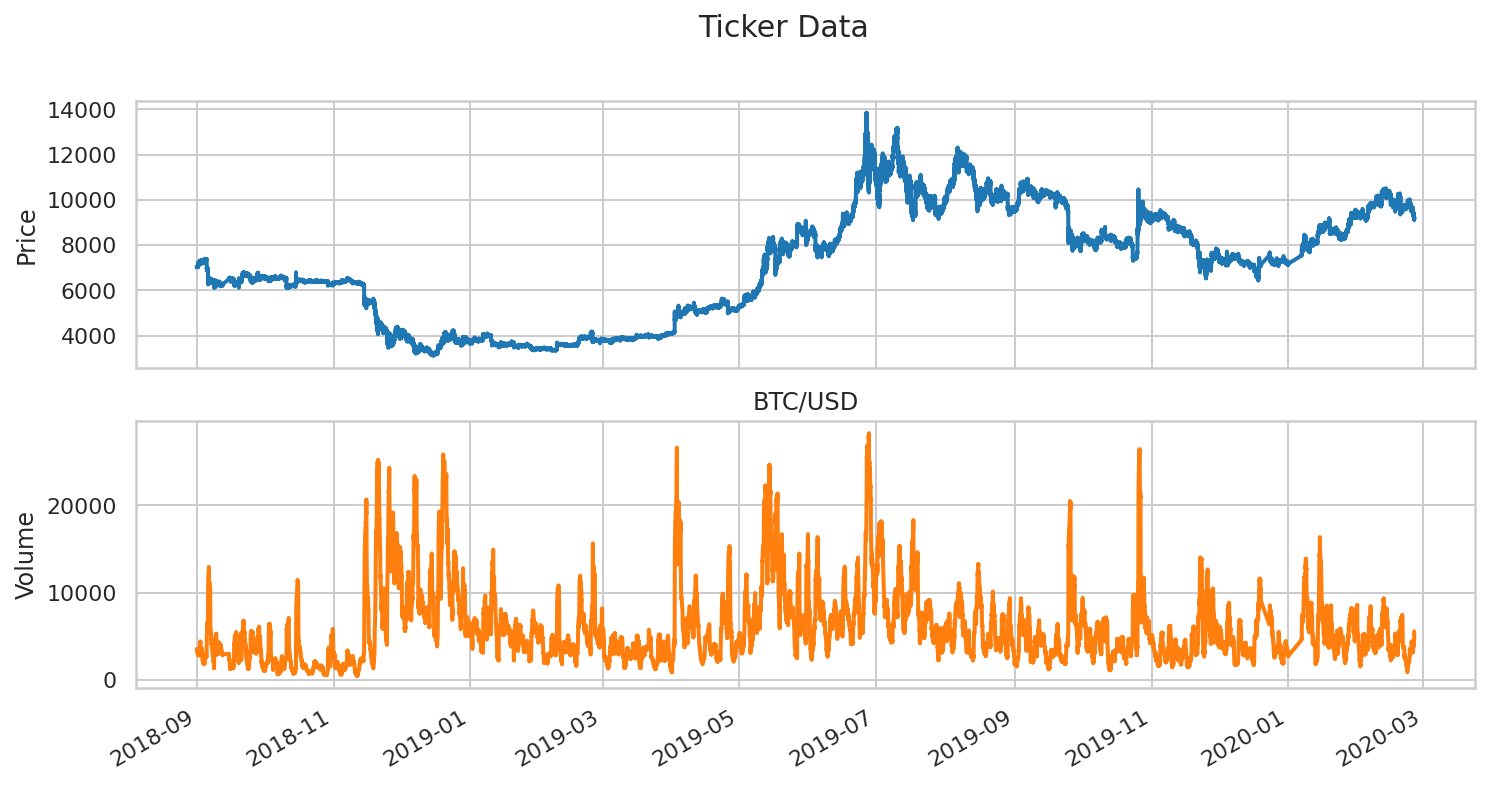

In [13]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(orderbook_prices.index, orderbook_prices['Price'], lw=2, label="training data")
ax.set_ylabel("Price")

ax = fig.add_subplot(2, 1, 2)

ax.plot(ticker_table['__index_level_0__'], ticker_table['Volume'], lw=2, label="training data", c=c2)
ax.set_ylabel("Volume")
ax.set_title("BTC/USD")
fig.suptitle("Ticker Data",
             fontsize=15)
fig.autofmt_xdate()

In [14]:
lob_depthes = orderbook_df_part.columns[1:].to_numpy().astype('float')
lob_depthes_renorm = np.logspace(np.log10(.5e-6),np.log10(.005), 51)
lob_data = orderbook_df_part.iloc[1000]

volume = volume_f(lob_data.name.to_datetime64().astype('float'))
bids_prices_norm = np.log(lob_data.Price) + lob_depthes[:int(len(lob_depthes)/2)]
asks_prices_norm = np.log(lob_data.Price) + lob_depthes[int(len(lob_depthes)/2):]
bids_vol_norm = lob_data.to_numpy()[1:int(len(lob_depthes)/2 + 1)]
asks_vol_norm = lob_data.to_numpy()[int(len(lob_depthes)/2 + 1):]
bids_volsum_norm = np.cumsum(bids_vol_norm)
asks_volsum_norm = np.cumsum(asks_vol_norm)
bids_prices_renorm = - lob_depthes_renorm + np.log(lob_data.Price)
bids_vol_f = interpolate.interp1d(bids_prices_norm, bids_volsum_norm, bounds_error=False,
    fill_value=(0,bids_volsum_norm[-1]), 
    kind="linear")
bids_volsum_renorm = bids_vol_f(bids_prices_renorm)
bids_vol_renorm=np.diff(bids_volsum_renorm, prepend=0)
asks_prices_renorm = + lob_depthes_renorm + np.log(lob_data.Price)
asks_vol_f = interpolate.interp1d(asks_prices_norm, asks_volsum_norm, bounds_error=False,
    fill_value=(0, asks_volsum_norm[-1]), 
    kind="linear")
asks_volsum_renorm = asks_vol_f(asks_prices_renorm)
asks_vol_renorm=np.diff(asks_volsum_renorm, prepend=0)    

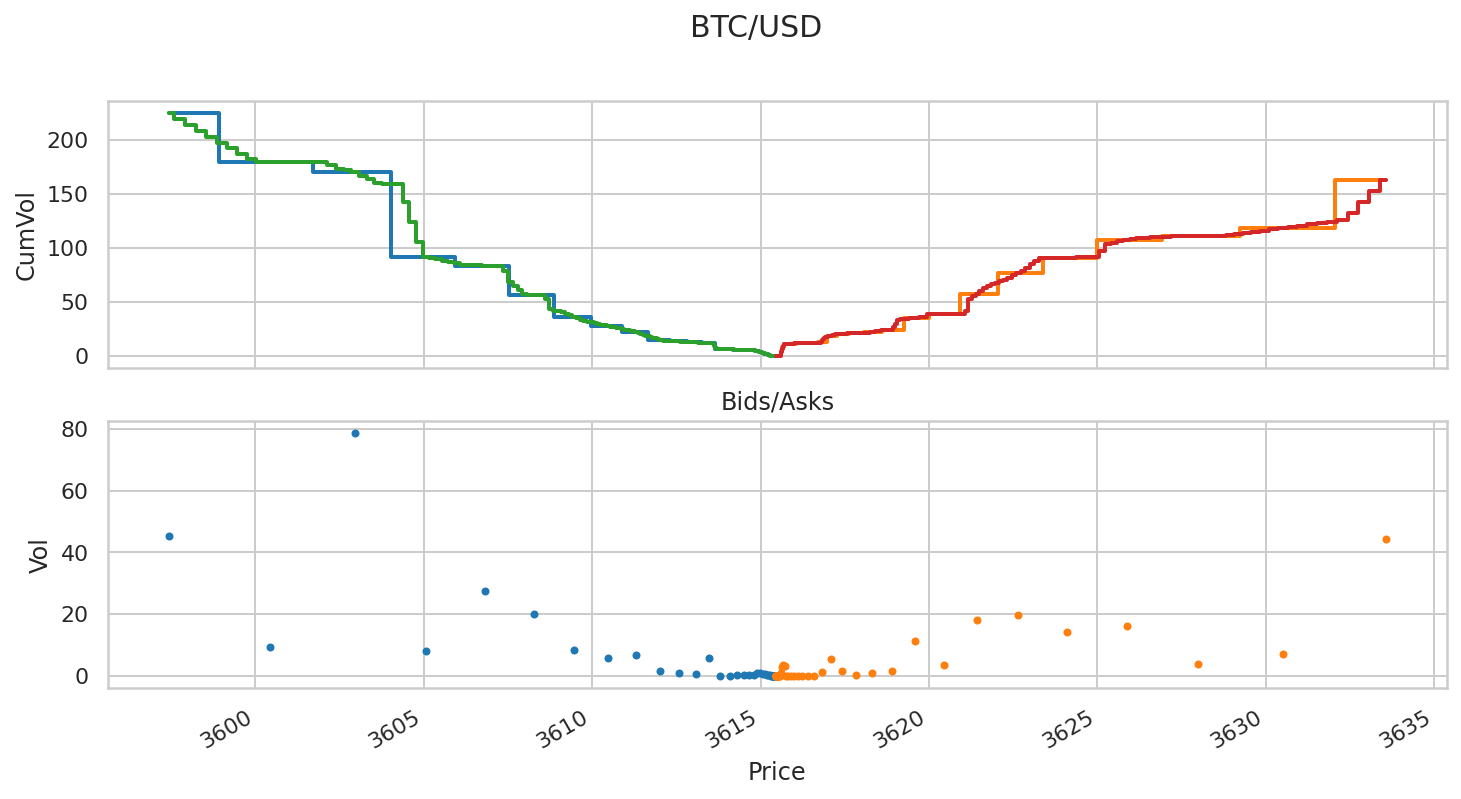

In [15]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.exp(bids_prices_renorm), bids_volsum_renorm, lw=2, label="training data", drawstyle='steps-mid')
ax.plot(np.exp(asks_prices_renorm), asks_volsum_renorm, lw=2, label="training data", drawstyle='steps-mid')
ax.plot(np.exp(bids_prices_norm), bids_volsum_norm, lw=2, label="training data", drawstyle='steps-mid')
ax.plot(np.exp(asks_prices_norm), asks_volsum_norm, lw=2, label="training data", drawstyle='steps-mid')
ax.set_ylabel("CumVol")
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.exp(bids_prices_renorm), bids_vol_renorm, ls='', marker='.', label="training data")
ax.plot(np.exp(asks_prices_renorm), asks_vol_renorm, ls='', marker='.', label="training data")
#ax.plot(np.exp(bids_prices_norm), bids_vol_norm, ls='', marker='.', label="training data")
#ax.plot(np.exp(asks_prices_norm), asks_vol_norm, ls='', marker='.', label="training data")
ax.set_ylabel("Vol")
ax.set_xlabel("Price")
ax.set_title("Bids/Asks")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

In [16]:
lob_depthes = orderbook_df_part.columns[1:].to_numpy().astype('float')
lob_depthes_renorm = np.logspace(np.log10(.5e-6),np.log10(.005), 51)
lob_data = orderbook_df_part.iloc[1000]

def renorm_orderbook(lob_data, volume_f, lob_depthes, lob_depthes_renorm):
    volume = volume_f(lob_data.name.to_datetime64().astype('float'))
    bids_prices_norm = np.log(lob_data.Price) + lob_depthes[:int(len(lob_depthes)/2)]
    asks_prices_norm = np.log(lob_data.Price) + lob_depthes[int(len(lob_depthes)/2):]
    bids_vol_norm = lob_data.to_numpy()[1:int(len(lob_depthes)/2 + 1)]
    asks_vol_norm = lob_data.to_numpy()[int(len(lob_depthes)/2 + 1):]
    bids_volsum_norm = np.cumsum(bids_vol_norm)
    asks_volsum_norm = np.cumsum(asks_vol_norm)
    bids_prices_renorm = - lob_depthes_renorm + np.log(lob_data.Price)
    bids_vol_f = interpolate.interp1d(bids_prices_norm, bids_volsum_norm, bounds_error=False,
        fill_value=(0,bids_volsum_norm[-1]), 
        kind="linear")
    bids_volsum_renorm = bids_vol_f(bids_prices_renorm)
    bids_vol_renorm=np.diff(bids_volsum_renorm, prepend=0)
    asks_prices_renorm = + lob_depthes_renorm + np.log(lob_data.Price)
    asks_vol_f = interpolate.interp1d(asks_prices_norm, asks_volsum_norm, bounds_error=False,
        fill_value=(0, asks_volsum_norm[-1]), 
        kind="linear")
    asks_volsum_renorm = asks_vol_f(asks_prices_renorm)
    asks_vol_renorm=np.diff(asks_volsum_renorm, prepend=0)    
    return np.concatenate([[lob_data.Price, volume], bids_vol_renorm, asks_vol_renorm])

renorm_orderbook(lob_data, volume_f, lob_depthes, lob_depthes_renorm)

array([3.61545000e+03, 4.44026970e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.11486017e-02, 3.53510909e-01,
       4.25013567e-01, 5.10978702e-01, 6.14331567e-01, 7.38588912e-01,
       8.87979227e-01, 1.06758586e+00, 2.60422488e-01, 2.65451860e-01,
       3.19143333e-01, 2.27708712e-01, 6.34211918e-02, 2.03477383e-01,
       5.75771633e+00, 5.77405375e-01, 8.80948875e-01, 1.66338352e+00,
       6.78243594e+00, 5.98040235e+00, 8.39442657e+00, 1.99454470e+01,
       2.74075751e+01, 8.22202554e+00, 7.85413045e+01, 9.50850352e+00,
       4.52703008e+01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [17]:
orderbook_df = orderbook_dataset.to_table().to_pandas().drop(columns=['dt'])
gc.collect()
orderbook_df

,Price,-0.000000500000,-0.000000509296,-0.000000518764,-0.000000528409,-0.000000538233,-0.000000548239,-0.000000558432,-0.000000568814,-0.000000579389,...,0.004236137071,0.004314892739,0.004395112584,0.004476823828,0.004560054197,0.004644831934,0.004731185807,0.004819145118,0.004908739715,0.005000000000
2018-09-01 00:00:38.099,7014.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000470,0.000347,0.000353,0.000360,0.000367,0.000373,0.000380,0.000387,4.616215,8.128701
2018-09-01 00:01:08.279,7015.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000340,0.000347,0.000353,0.000360,0.000367,0.000373,0.000380,7.429099,7.980336,3.128214
2018-09-01 00:01:35.032,7025.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.200961,0.048026,0.048919,0.127002,10.526656,5.583125,0.132513,0.134976,0.137486,0.041646
2018-09-01 00:02:25.562,7024.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.730548,2.771652,0.689174,0.049829,0.076114,3.614957,12.509924,0.134976,0.137486,0.140042
2018-09-01 00:02:58.204,7022.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.238526,0.245068,0.323323,0.329334,2.150676,2.774085,0.261334,0.053639,0.120911,10.315744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 02:45:58.354,9188.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.083138,5.177641,1.844406,0.880146,0.725683,0.028736,0.068976,0.070258,0.579055,1.701159
2020-02-26 02:46:28.255,9191.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.697814,0.048227,0.049123,0.050036,0.064953,1.580319,1.609700,4.685557,7.577427,7.718302
2020-02-26 02:46:58.232,9197.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.539157,6.660729,6.784561,6.910695,2.301684,4.829634,8.950559,0.390178,0.376021,0.094197
2020-02-26 02:47:28.126,9198.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.641450,8.802106,4.101272,1.286914,12.712906,0.487395,0.496456,0.095459,0.083229,0.693612


In [18]:
lob_depthes = orderbook_df.columns[1:].to_numpy().astype('float')
lob_depthes_renorm = np.logspace(np.log10(.5e-6),np.log10(.005), 51)

def renorm(i):
    return renorm_orderbook(orderbook_df.iloc[i], volume_f, lob_depthes, lob_depthes_renorm)
with mp.Pool() as pool:
    str_arr = np.frompyfunc("{:.12f}".format, 1,1)
    lob_depthes_str = str_arr(np.concatenate((- lob_depthes_renorm, lob_depthes_renorm)))
    orderbook_df_renorm = pd.DataFrame(
        data=pool.map(renorm, range(len(orderbook_df))), 
        index=orderbook_df.index, 
        columns=np.concatenate((['Price', 'Volume'],lob_depthes_str)))
del renorm
del orderbook_df
gc.collect()
orderbook_df = orderbook_df_renorm
orderbook_df

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:38.099,7014.15,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.341822,1.548986,0.740800,12.403959,7.812394,7.043460,20.320484,8.358179,3.819088,12.747953
2018-09-01 00:01:08.279,7015.00,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.795573,0.422924,0.655283,15.096659,1.635545,20.260953,14.012626,14.014523,1.523370,18.540169
2018-09-01 00:01:35.032,7025.35,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.860956,9.395285,6.942962,5.112859,31.153116,7.857127,0.122409,14.516972,10.720042,16.981310
2018-09-01 00:02:25.562,7024.45,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.465715,2.439799,4.693501,4.079939,17.744298,3.566261,15.486729,18.878018,3.738062,21.854702
2018-09-01 00:02:58.204,7022.25,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.849214,4.494117,1.505980,5.340220,1.411890,14.928768,12.920231,17.046585,7.867853,16.812640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 02:45:58.354,9188.05,5596.983156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.658354,7.371861,25.784423,15.253162,6.188698,20.257519,15.904370,24.753177,13.056150,16.159197
2020-02-26 02:46:28.255,9191.00,5596.983156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.181324,8.643010,10.769438,11.456250,16.324232,14.069314,15.707893,15.060445,26.518260,24.081457
2020-02-26 02:46:58.232,9197.30,5596.983156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.549184,2.518253,9.201763,28.199696,9.237407,14.817904,18.497153,26.620468,17.838292,43.837415
2020-02-26 02:47:28.126,9198.65,5596.983156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.848163,1.665824,2.133913,21.720253,22.891053,20.436144,7.525413,29.305244,34.184758,37.400800


In [19]:
input_seq_len = 200
output_seq_len = 20
n_in_features = 1
n_out_features = 1
batch_size = 10

In [20]:
total_start_points = 10000
range_start_points = len(orderbook_df) - input_seq_len - output_seq_len
range_start_points = int(len(orderbook_df)*.90)

orderbook_df.iloc[[0, range_start_points, len(orderbook_df) - 1]]

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:38.099,7014.15,3496.549764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.341822,1.548986,0.740800,12.403959,7.812394,7.043460,20.320484,8.358179,3.819088,12.747953
2019-12-30 21:32:04.950,7238.50,3593.813120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.814125,7.151191,23.271046,0.115941,0.431598,17.109590,7.039971,27.792711,10.389203,20.353852
2020-02-26 02:47:58.335,9198.95,5596.983156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.105269,5.036479,1.566687,2.770739,26.809865,24.501037,10.056602,23.654927,15.596395,69.438732


In [21]:
rng = default_rng(0)

In [22]:
start_orderbook_ilocs = rng.choice(range(range_start_points), total_start_points, replace = False)
start_orderbook_ilocs

array([ 541980,  641229,  860973, ..., 1192738,  853280,  259486])

In [23]:
start_orderbook_idx = orderbook_df.iloc[start_orderbook_ilocs].index
start_orderbook_mask_prev = ticker_df_clean.index.get_indexer(start_orderbook_idx, method='pad', tolerance=pd.Timedelta('30min'))
start_orderbook_mask_next = ticker_df_clean.index.get_indexer(start_orderbook_idx, method='backfill', tolerance=pd.Timedelta('30min'))

end_orderbook_idx = orderbook_df.iloc[start_orderbook_ilocs + input_seq_len + output_seq_len].index
end_orderbook_mask_prev = ticker_df_clean.index.get_indexer(end_orderbook_idx, method='pad', tolerance=pd.Timedelta('30min'))
end_orderbook_mask_next = ticker_df_clean.index.get_indexer(end_orderbook_idx, method='backfill', tolerance=pd.Timedelta('30min'))

orderbook_mask_tmp = np.concatenate(
    [
        start_orderbook_ilocs, 
        start_orderbook_mask_prev, 
        start_orderbook_mask_next,
        end_orderbook_mask_prev,
        end_orderbook_mask_next
    ]
    ).reshape(5, -1).T

orderbook_mask_tmp = orderbook_mask_tmp[
    np.where(
        (start_orderbook_mask_prev + 1)
        *(start_orderbook_mask_next + 1)
        *(end_orderbook_mask_prev + 1)
        *(end_orderbook_mask_next + 1)
         > 0)]
start_orderbook_ilocs_clean = orderbook_mask_tmp.T[:1].T.reshape(-1)
start_orderbook_mask_clean = orderbook_mask_tmp.T[1:3].T.reshape(-1)
end_orderbook_mask_clean = orderbook_mask_tmp.T[3:5].T.reshape(-1)
orderbook_mask_clean = orderbook_mask_tmp.T[1:].T.reshape(-1)

(
    len(start_orderbook_ilocs_clean),
    len(start_orderbook_mask_clean),
    len(end_orderbook_mask_clean),
    len(orderbook_mask_clean)
)

(8374, 16748, 16748, 33496)

In [24]:
ticker_df_clean.iloc[orderbook_mask_clean]

,Price,Volume,Bid,Ask
2019-03-15 06:37:00.077,3862.2,3788.606426,3862.2,3862.9
2019-03-15 06:46:52.946,3861.6,3768.163546,3860.1,3861.0
2019-03-15 08:36:50.485,3855.8,3806.005813,3855.8,3857.0
2019-03-15 08:46:32.584,3855.4,3780.795393,3854.0,3854.6
2019-05-04 04:29:22.278,5715.0,12046.500862,5715.0,5715.1
...,...,...,...,...
2019-07-18 18:02:20.919,10587.9,13347.285343,10587.9,10588.0
2018-12-05 03:21:55.784,3850.4,9001.044251,3847.0,3850.4
2018-12-05 03:32:04.359,3837.3,8963.660502,3840.2,3842.5
2018-12-05 05:12:00.150,3823.0,9124.528845,3823.0,3823.1


In [25]:
batch_orderbook_ilocs = np.array([list(range(i, i+input_seq_len+output_seq_len)) for i in start_orderbook_ilocs_clean])
batch_orderbook_ilocs.shape

(8374, 220)

In [26]:
batch_orderbook = orderbook_df.iloc[batch_orderbook_ilocs.reshape(-1)]
batch_orderbook

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2019-03-15 06:45:30.474,3861.00,3771.007286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.516154,1.298828,16.924041,8.622457,22.838005,18.778235,8.108938,14.701395,28.379854,6.895748
2019-03-15 06:46:05.844,3860.70,3769.787683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.516154,1.442226,15.873085,5.668017,33.284352,17.314667,10.118722,13.851808,22.376442,7.462014
2019-03-15 06:46:49.920,3860.80,3768.267886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.575511,5.339227,22.418622,5.862628,23.408178,18.236129,10.419650,14.282371,22.346373,7.029786
2019-03-15 06:47:00.986,3860.50,3768.144359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.630702,0.791581,25.280744,7.174211,13.171913,14.663146,13.068914,14.183318,22.464244,8.428612
2019-03-15 06:47:42.431,3857.05,3768.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.933170,12.106992,3.692197,10.743158,11.021298,13.749643,11.160795,15.703209,9.922363,11.215573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-05 05:12:20.887,3826.80,9123.201418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.504148,0.834151,0.853609,1.216151,7.374093,11.915664,18.047255,12.774927,30.873529,26.596739
2018-12-05 05:12:52.557,3825.95,9121.174142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.805779,3.329550,17.781679,1.111815,2.363872,2.353469,35.815188,12.107033,20.148100,15.537377
2018-12-05 05:13:27.482,3825.85,9118.938506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.278963,16.201457,8.420648,1.040221,2.286196,2.997544,35.209428,12.671440,19.917259,15.127392
2018-12-05 05:13:57.507,3825.75,9117.016530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.409592,5.985554,3.242660,1.026264,1.994862,3.181890,28.380055,13.199529,17.623078,16.762178


In [27]:
gc.collect()

0

In [28]:
batch_orderbook.to_numpy()

array([[3.86100000e+03, 3.77100729e+03, 0.00000000e+00, ...,
        1.47013949e+01, 2.83798543e+01, 6.89574789e+00],
       [3.86070000e+03, 3.76978768e+03, 0.00000000e+00, ...,
        1.38518077e+01, 2.23764420e+01, 7.46201408e+00],
       [3.86080000e+03, 3.76826789e+03, 0.00000000e+00, ...,
        1.42823707e+01, 2.23463733e+01, 7.02978607e+00],
       ...,
       [3.82585000e+03, 9.11893851e+03, 0.00000000e+00, ...,
        1.26714396e+01, 1.99172593e+01, 1.51273922e+01],
       [3.82575000e+03, 9.11701653e+03, 0.00000000e+00, ...,
        1.31995292e+01, 1.76230783e+01, 1.67621781e+01],
       [3.82470000e+03, 9.11537058e+03, 0.00000000e+00, ...,
        2.44132179e+01, 2.10237743e+01, 2.58344432e+01]])

In [29]:
orderbook_nd =orderbook_df.to_numpy()
orderbook_nd_max = orderbook_nd[:,2:].max()
orderbook_nd_min = orderbook_nd[:,2:].min()
[orderbook_nd_min, orderbook_nd_max]

[0.0, 984.2184556077125]

In [30]:
orderbook_index_max = np.unravel_index(np.argmax(orderbook_nd[:,2:], axis=None), orderbook_nd[:,2:].shape)
lob_data = orderbook_df.iloc[orderbook_index_max[0]]
volume_f(lob_data.name.to_datetime64().astype('float')), lob_data

(array(11738.15352552),
 Price               3667.550000
 Volume             11738.153526
 -0.000000500000        0.000000
 -0.000000601132        0.000000
 -0.000000722720        0.000000
                        ...     
 0.002393150462         0.057902
 0.002877199687         1.161204
 0.003459154855        19.513438
 0.004158818856        23.979501
 0.005000000000        11.676561
 Name: 2018-12-19 00:00:07.029000, Length: 104, dtype: float64)

In [31]:
lob_depthes = orderbook_df.columns[2:].to_numpy().astype('float')
bids_prices_norm = np.log(lob_data.Price) + lob_depthes[:int(len(lob_depthes)/2)]
asks_prices_norm = np.log(lob_data.Price) + lob_depthes[int(len(lob_depthes)/2):]
bids_vol_norm = lob_data.to_numpy()[2:int(len(lob_depthes)/2 + 2)]
asks_vol_norm = lob_data.to_numpy()[int(len(lob_depthes)/2 + 2):]
bids_volsum_norm = np.cumsum(bids_vol_norm)
asks_volsum_norm = np.cumsum(asks_vol_norm)
(len(bids_prices_norm),len(asks_prices_norm),len(bids_vol_norm),len(asks_vol_norm),len(bids_volsum_norm),len(asks_volsum_norm))

(51, 51, 51, 51, 51, 51)

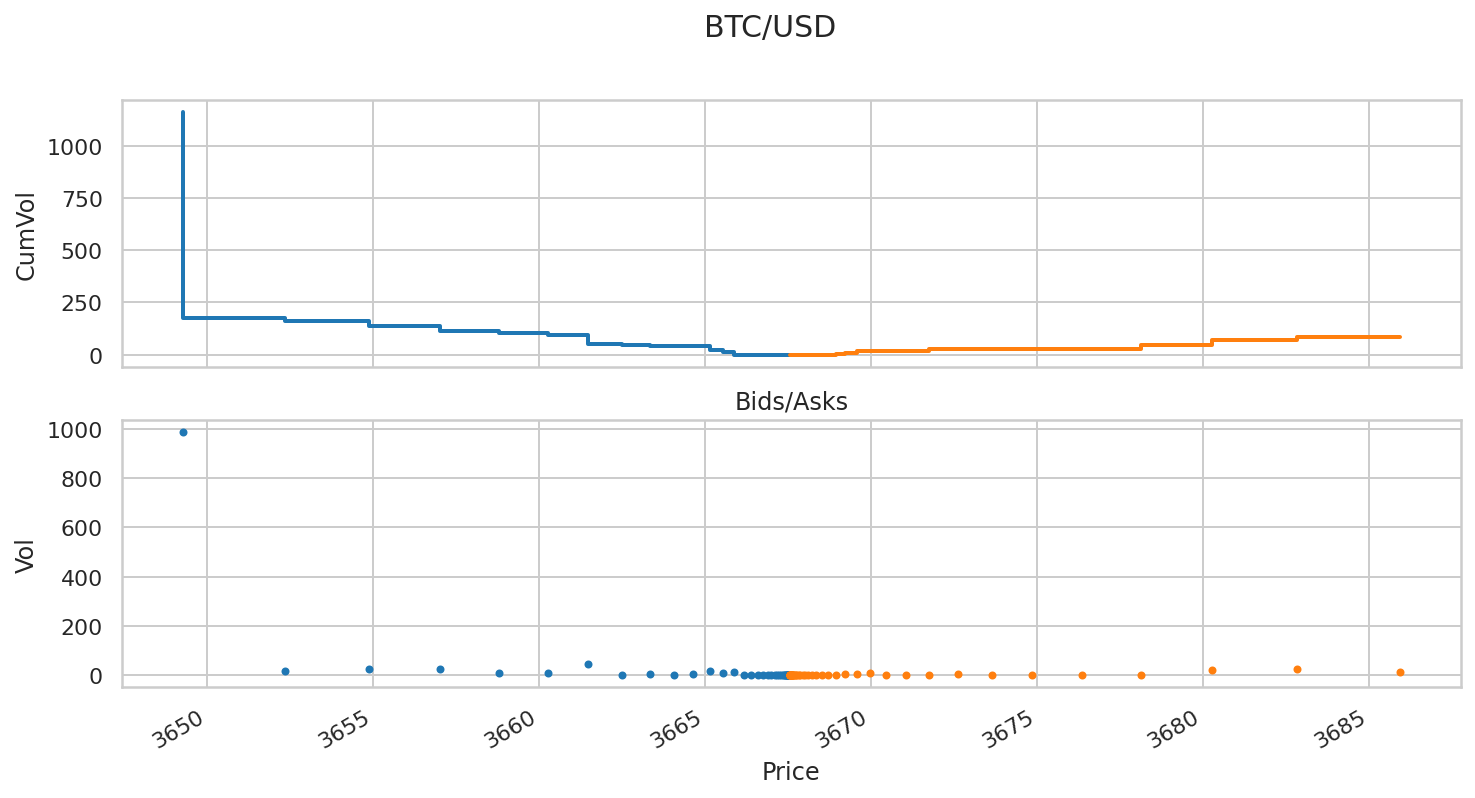

In [32]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.exp(bids_prices_norm), bids_volsum_norm, lw=2, label="training data", drawstyle='steps-post')
ax.plot(np.exp(asks_prices_norm), asks_volsum_norm, lw=2, label="training data", drawstyle='steps-pre')
ax.set_ylabel("CumVol")
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.exp(bids_prices_norm), bids_vol_norm, ls='', marker='.', label="training data")
ax.plot(np.exp(asks_prices_norm), asks_vol_norm, ls='', marker='.', label="training data")
ax.set_ylabel("Vol")
ax.set_xlabel("Price")
ax.set_title("Bids/Asks")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

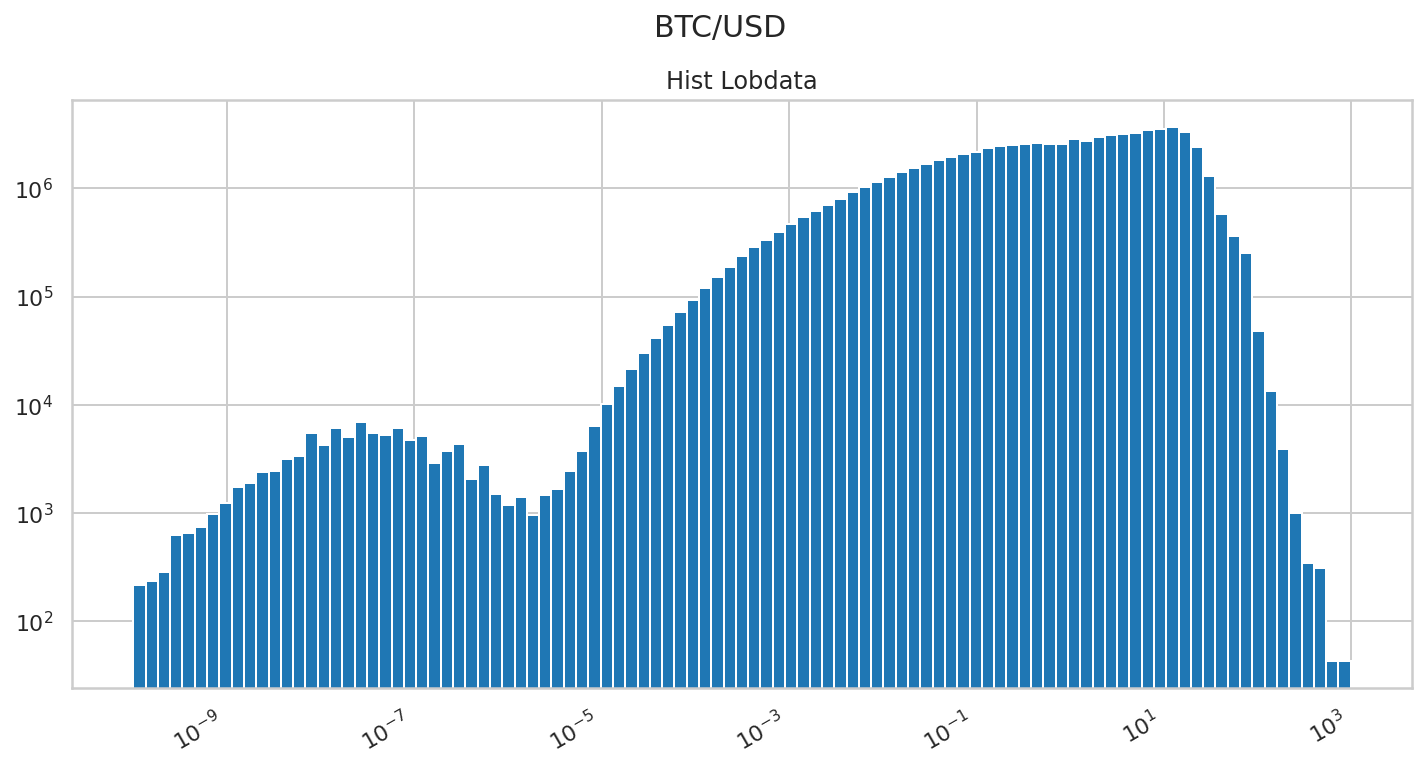

In [33]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
logbins = np.geomspace(1e-10, orderbook_nd_max, 100)
ax.hist(orderbook_nd[:,2:].reshape(-1), bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Hist Lobdata")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

In [34]:
logbins = np.geomspace(1e-6, orderbook_nd_max, 30)
np.histogram(orderbook_nd[:,2:].reshape(-1), bins=logbins)

(array([   2924,    3637,    8961,   27270,   63347,  129379,  241357,
         422094,  681390, 1003193, 1426655, 1935425, 2571109, 3301545,
        4047139, 4746446, 5500046, 5944940, 6092772, 6490495, 7109506,
        7697007, 8450069, 6684094, 1758987,  464622,   20349,    1193,
            172]),
 array([1.00000000e-06, 2.04223918e-06, 4.17074086e-06, 8.51765040e-06,
        1.73950794e-05, 3.55249126e-05, 7.25503683e-05, 1.48165205e-04,
        3.02588786e-04, 6.17958674e-04, 1.26201941e-03, 2.57734549e-03,
        5.26355594e-03, 1.07494402e-02, 2.19529279e-02, 4.48331294e-02,
        9.15599734e-02, 1.86987365e-01, 3.81872922e-01, 7.79875844e-01,
        1.59269300e+00, 3.25266005e+00, 6.64270979e+00, 1.35660022e+01,
        2.77050212e+01, 5.65802797e+01, 1.15550464e+02, 2.35981685e+02,
        4.81931042e+02, 9.84218456e+02]))

In [35]:
np.log10(np.exp(25))

10.857362047581296

In [36]:
orderbook_nd_price_volume_scaled = np.log(orderbook_nd[:,0:2])
(orderbook_nd_price_volume_scaled[:,0].min(),
orderbook_nd_price_volume_scaled[:,0].max(),
orderbook_nd_price_volume_scaled[:,1].min(),
orderbook_nd_price_volume_scaled[:,1].max())

(8.047349549371868, 9.536069392064867, 6.189205893202037, 10.249033853817284)

In [37]:
clip_high_price=10.5
clip_low_price=7
clip_high_volume=13
clip_low_volume=5
orderbook_nd_price_volume_scaled = np.log(orderbook_nd[:,0:2])
orderbook_nd_price_volume_scaled[orderbook_nd_price_volume_scaled[:,0]<clip_low_price,0]=clip_low_price
orderbook_nd_price_volume_scaled[orderbook_nd_price_volume_scaled[:,0]>clip_high_price,0]=clip_high_price
orderbook_nd_price_volume_scaled[orderbook_nd_price_volume_scaled[:,1]<clip_low_volume,1]=clip_low_volume
orderbook_nd_price_volume_scaled[orderbook_nd_price_volume_scaled[:,1]>clip_high_volume,1]=clip_high_volume
orderbook_nd_price_volume_scaled=(2*(orderbook_nd_price_volume_scaled-np.array((clip_low_price,clip_low_volume)))/
        (np.array((clip_high_price,clip_high_volume))-np.array((clip_low_price,clip_low_volume)))-1)

(orderbook_nd_price_volume_scaled[:,0].min(),
orderbook_nd_price_volume_scaled[:,0].max(),
orderbook_nd_price_volume_scaled[:,1].min(),
orderbook_nd_price_volume_scaled[:,1].max())

(-0.4015145432160756,
 0.44918250975135265,
 -0.7026985266994907,
 0.31225846345432107)

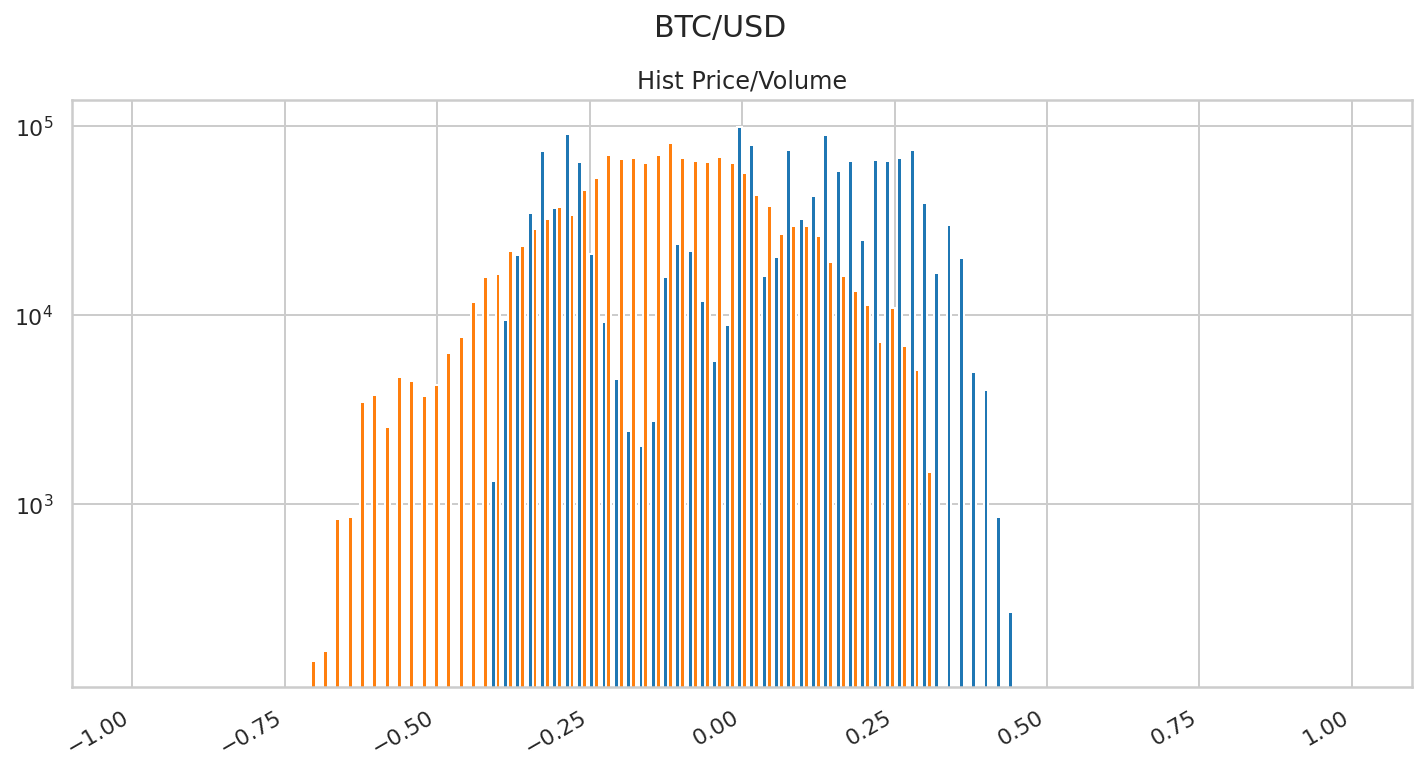

In [38]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
bins = np.linspace(-1, 1, 100)
ax.hist(orderbook_nd_price_volume_scaled, bins=bins)
ax.set_yscale('log')
ax.set_title("Hist Price/Volume")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

In [39]:
clip_high=13
clip_low=-25
orderbook_nd_scaled = np.log(orderbook_nd[:,2:])
orderbook_nd_scaled[orderbook_nd_scaled<clip_low]=clip_low
orderbook_nd_scaled[orderbook_nd_scaled>clip_high]=clip_high
orderbook_nd_scaled=2*(orderbook_nd_scaled-clip_low)/(clip_high-clip_low)-1

In [40]:
bins = np.linspace(-1, 1, 100)
np.histogram(orderbook_nd_scaled.reshape(-1), bins=bins)

(array([71373942,       28,       63,      105,      179,      255,
             314,      497,      917,      931,     1368,     2000,
            2316,     3016,     3495,     4234,     6451,     5575,
            7429,     8010,     7359,     7743,     6303,     6267,
            3610,     6005,     3159,     3330,     1777,     1835,
            1295,     1768,     2257,     3977,     7252,    13410,
           21383,    33489,    50035,    71974,   101421,   140650,
          188976,   253457,   329990,   411148,   503014,   617749,
          744405,   874169,  1032859,  1219937,  1397919,  1609402,
         1834752,  2030938,  2264431,  2468745,  2637924,  2887611,
         3085770,  3161098,  3286866,  3282621,  3269871,  3595317,
         3569357,  3895091,  4051200,  4210837,  4419035,  4654455,
         4139438,  2602521,  1040290,   483364,   273350,    38593,
            6777,     1610,      449,      197,       30,       19,
               0,        0,        0,        0, 

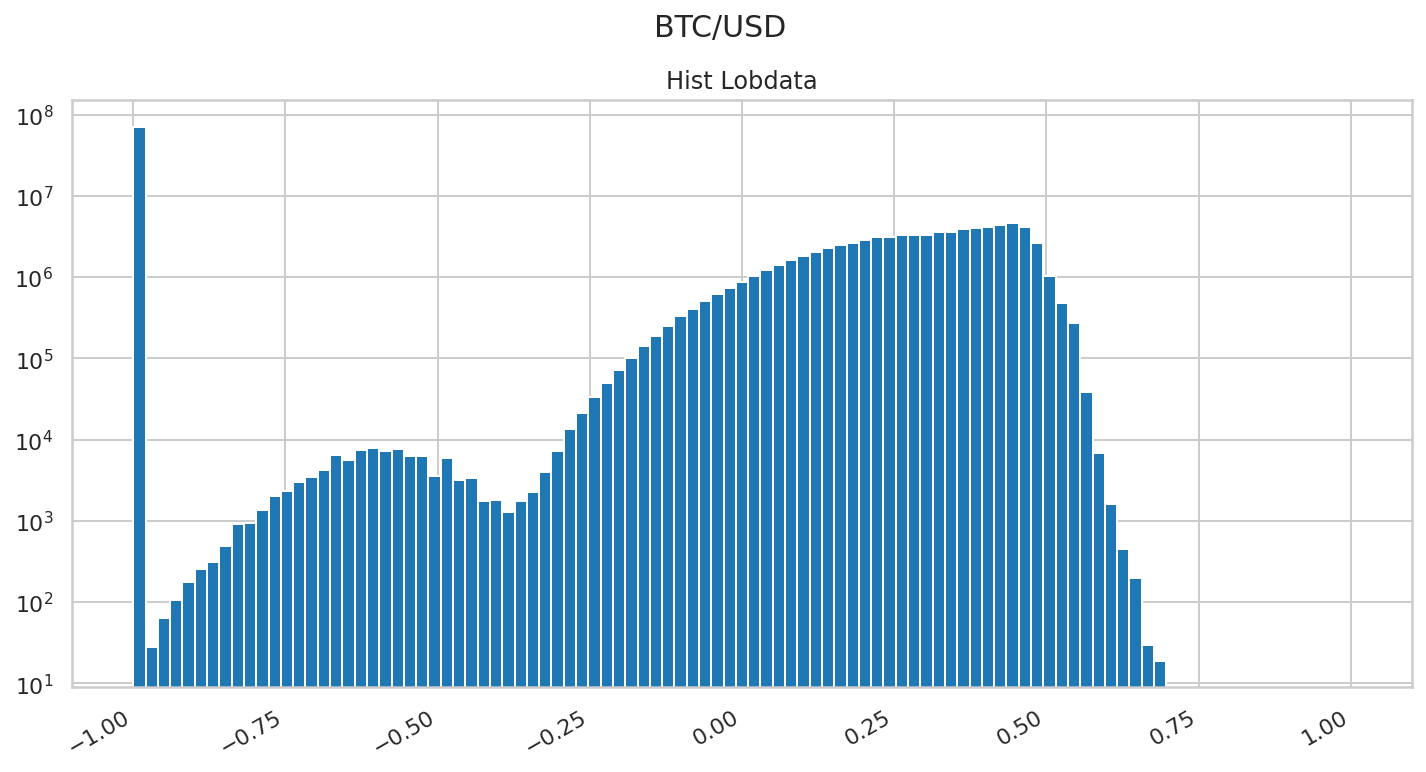

In [41]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
bins = np.linspace(-1, 1, 100)
ax.hist(orderbook_nd_scaled.reshape(-1), bins=bins)
ax.set_yscale('log')
ax.set_title("Hist Lobdata")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()


In [42]:
lob_cut = 0.25
lob_indexes = np.r_[
    2:2+int(lob_cut*(orderbook_nd.shape[1]-2)/2),
    2+int((orderbook_nd.shape[1]-2)/2):2+int((orderbook_nd.shape[1]-2)/2)+int(lob_cut*(orderbook_nd.shape[1]-2)/2)
]

orderbook_nd_cut = orderbook_nd[:,lob_indexes]

orderbook_nd_cut_index_max = np.unravel_index(np.argmax(orderbook_nd_cut, axis=None), orderbook_nd_cut.shape)
orderbook_nd_cut[orderbook_nd_cut_index_max]

47.23708973468283

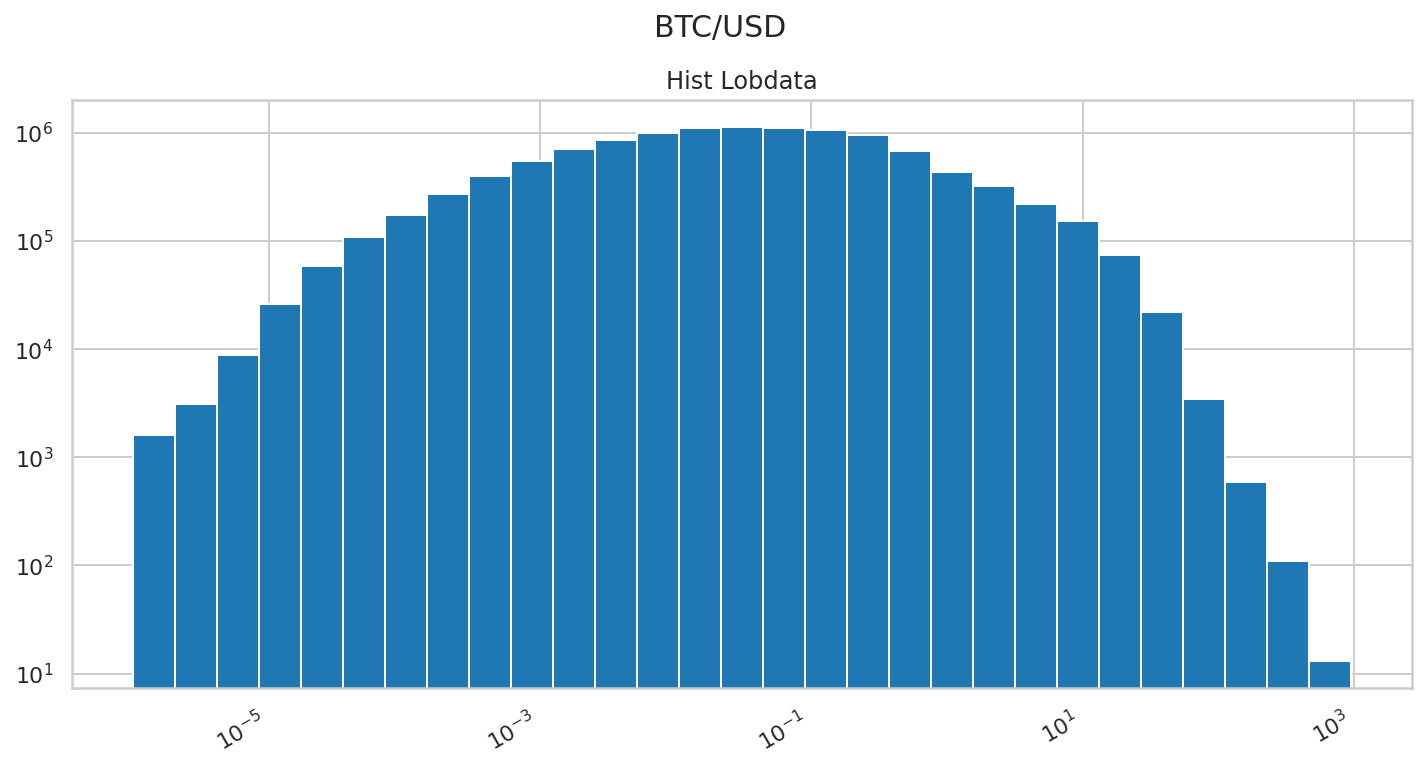

In [49]:
lob_cut = 0.5
lob_indexes = np.r_[
    2:2+int(lob_cut*(orderbook_nd.shape[1]-2)/2),
    2+int((orderbook_nd.shape[1]-2)/2):2+int((orderbook_nd.shape[1]-2)/2)+int(lob_cut*(orderbook_nd.shape[1]-2)/2)
]

orderbook_nd_cut = orderbook_nd[:,lob_indexes]

orderbook_nd_cut_index_max = np.unravel_index(np.argmax(orderbook_nd_cut, axis=None), orderbook_nd_cut.shape)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
logbins = np.geomspace(1e-6, orderbook_nd_cut[orderbook_nd_cut_index_max], 30)
ax.hist(orderbook_nd_cut.reshape(-1), bins=logbins)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Hist Lobdata")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

In [52]:
lob_cut = 1
lob_indexes = np.r_[
    2:2+int(lob_cut*(orderbook_nd.shape[1]-2)/2),
    2+int((orderbook_nd.shape[1]-2)/2):2+int((orderbook_nd.shape[1]-2)/2)+int(lob_cut*(orderbook_nd.shape[1]-2)/2)
]

In [53]:
lob_slice = 25
lob_data = orderbook_df.iloc[orderbook_nd_cut_index_max[0]-lob_slice:+orderbook_nd_cut_index_max[0]+lob_slice+1,np.r_[0:2,lob_indexes]]

lob_depthes = orderbook_df.columns[lob_indexes].to_numpy().astype('float')
#bids_prices_norm = np.log(lob_data.Price) + lob_depthes[:int(len(lob_depthes)/2)]
#asks_prices_norm = np.log(lob_data.Price) + lob_depthes[int(len(lob_depthes)/2):]
bids_prices_norm = (np.log(lob_data.Price.to_numpy().reshape(-1)) + np.repeat(lob_depthes[:int(len(lob_depthes)/2)], lob_data.Price.shape[0]).reshape(-1,lob_data.Price.shape[0])).T
asks_prices_norm = (np.log(lob_data.Price.to_numpy().reshape(-1)) + np.repeat(lob_depthes[int(len(lob_depthes)/2):], lob_data.Price.shape[0]).reshape(-1,lob_data.Price.shape[0])).T
bids_prices_norm = (np.repeat(lob_depthes[:int(len(lob_depthes)/2)], lob_data.Price.shape[0]).reshape(-1,lob_data.Price.shape[0])).T
asks_prices_norm = (np.repeat(lob_depthes[int(len(lob_depthes)/2):], lob_data.Price.shape[0]).reshape(-1,lob_data.Price.shape[0])).T

bids_vol_norm = lob_data.to_numpy()[:,2:int(len(lob_depthes)/2 + 2)]
asks_vol_norm = lob_data.to_numpy()[:,int(len(lob_depthes)/2 + 2):]
bids_volsum_norm = np.cumsum(bids_vol_norm, axis=1)
asks_volsum_norm = np.cumsum(asks_vol_norm, axis=1)
(len(bids_prices_norm),len(asks_prices_norm),len(bids_vol_norm),len(asks_vol_norm),len(bids_volsum_norm),len(asks_volsum_norm))

(51, 51, 51, 51, 51, 51)

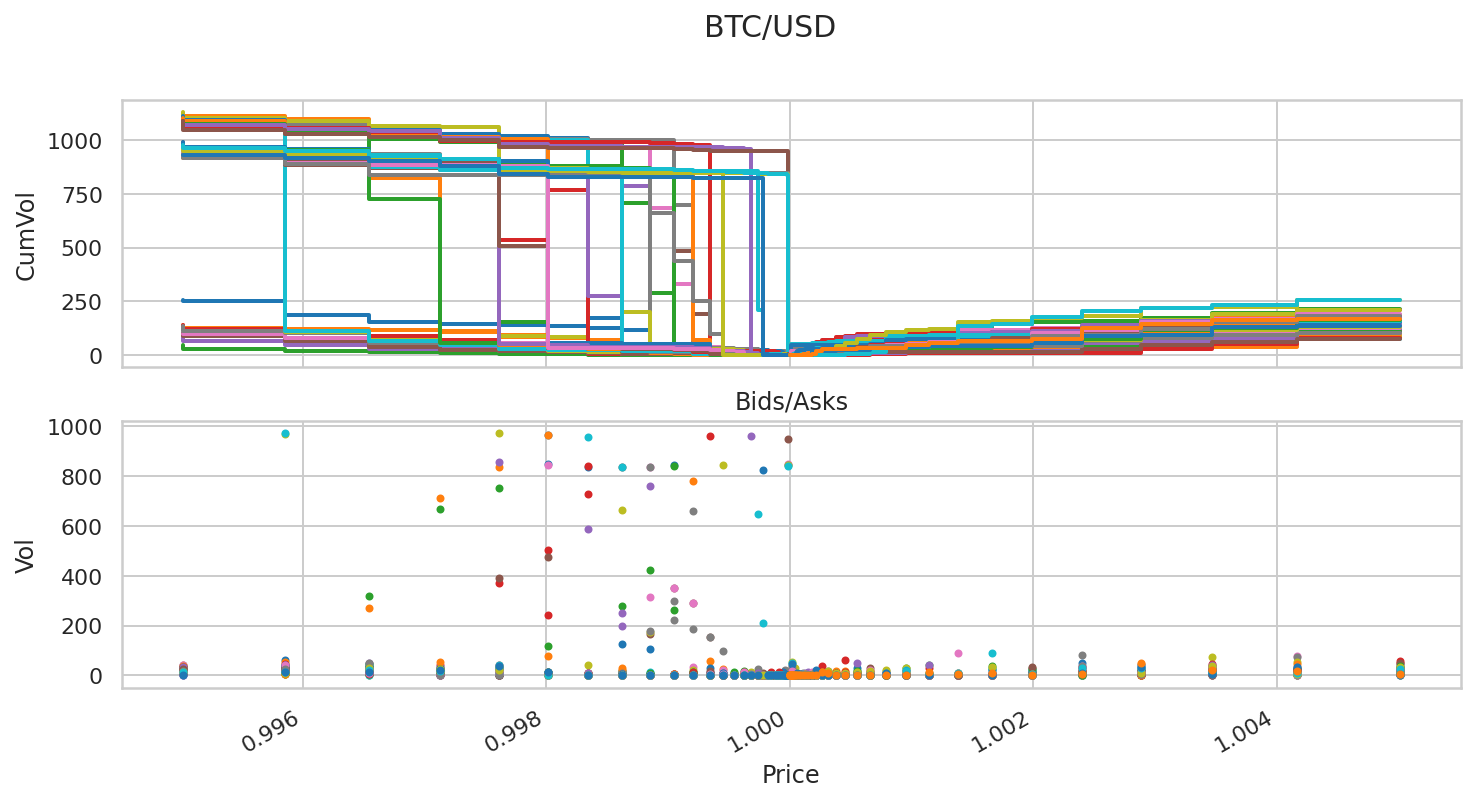

In [54]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(np.exp(bids_prices_norm).T, bids_volsum_norm.T, lw=2, label="training data", drawstyle='steps-post')
ax.plot(np.exp(asks_prices_norm).T, asks_volsum_norm.T, lw=2, label="training data", drawstyle='steps-pre')
ax.set_ylabel("CumVol")
ax = fig.add_subplot(2, 1, 2)
ax.plot(np.exp(bids_prices_norm).T, bids_vol_norm.T, ls='', marker='.', label="training data")
ax.plot(np.exp(asks_prices_norm).T, asks_vol_norm.T, ls='', marker='.', label="training data")
ax.set_ylabel("Vol")
ax.set_xlabel("Price")
ax.set_title("Bids/Asks")
fig.suptitle("BTC/USD",
             fontsize=15)
fig.autofmt_xdate()

In [47]:
orderbook_df_scaled = pd.DataFrame(
        data=np.concatenate((orderbook_nd_price_volume_scaled,orderbook_nd_scaled), axis=1), 
        index=orderbook_df.index, 
        columns=orderbook_df.columns)
orderbook_df_scaled

,Price,Volume,-0.000000500000,-0.000000601132,-0.000000722720,-0.000000868900,-0.000001044648,-0.000001255943,-0.000001509976,-0.000001815390,...,0.000952730359,0.001145433826,0.001377114352,0.001655655607,0.001990535853,0.002393150462,0.002877199687,0.003459154855,0.004158818856,0.005000000000
2018-09-01 00:00:38.099,0.060391,-0.210117,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.413009,0.338821,0.299999,0.448317,0.423985,0.418532,0.474296,0.427539,0.386316,0.449756
2018-09-01 00:01:08.279,0.060461,-0.210117,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.346596,0.270497,0.293543,0.458656,0.341683,0.474142,0.454735,0.454742,0.337943,0.469471
2018-09-01 00:01:35.032,0.061303,-0.210117,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.371113,0.433695,0.417775,0.401672,0.496785,0.424285,0.205243,0.456596,0.440638,0.464848
2018-09-01 00:02:25.562,0.061230,-0.210117,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.275569,0.362732,0.397167,0.389794,0.467161,0.382711,0.459999,0.470421,0.385188,0.478127
2018-09-01 00:02:58.204,0.061051,-0.210117,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.386730,0.394883,0.337339,0.403961,0.333944,0.458068,0.450463,0.465050,0.424357,0.464323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-26 02:45:58.354,0.214662,-0.092504,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.384053,0.420930,0.486830,0.459199,0.411722,0.474133,0.461400,0.484682,0.451014,0.462236
2020-02-26 02:46:28.255,0.214846,-0.092504,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.468442,0.429303,0.440880,0.444133,0.462771,0.454947,0.460745,0.458530,0.488307,0.483234
2020-02-26 02:46:58.232,0.215237,-0.092504,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.434550,0.364398,0.432600,0.491543,0.432803,0.457676,0.469348,0.488509,0.467439,0.514763
2020-02-26 02:47:28.126,0.215321,-0.092504,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.417052,0.342648,0.355682,0.477802,0.480566,0.474595,0.422015,0.493567,0.501673,0.506405


In [48]:
orderbook_df_scaled_table = pa.Table.from_pandas(orderbook_df_scaled, preserve_index=True)
pq.write_table(orderbook_df_scaled_table, f'/data/orderbook_scaled_{exchange}.parquet')